In [1]:
import csv
import xml.etree.ElementTree as ET
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys, os
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *

from data_manager import *
from metadata import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


Setting environment for AWS compute node


In [83]:
stack = 'LM40'
# stack = 'LM30'
xmlfile = '/shared/lauren_data/%s_export.xml' % stack
download_from_s3(xmlfile)

In [84]:
# create element tree object
tree = ET.parse(xmlfile)

# get root element
root = tree.getroot()

prefix = '{http://www.mbfbioscience.com/2007/neurolucida}'

neurolucida_name_map = \
{"Contour Name 1": 'RMC',
"Contour Name 2": '3N',
"Contour Name 3": 'fr',
'Brain': 'outerContour',
 'SNR': 'SNR'}

In [85]:
contours = defaultdict(list)

for item in root.findall(prefix+'contour'):
    name = neurolucida_name_map[item.attrib['name']]
    curr_contour = []
#     try:
#         resolution = float(item.findall(prefix+'resolution')[0].text)
#         print resolution
#     except:
#         pass
    for p in item.findall(prefix+'point'):
        curr_contour.append((float(p.attrib['x']), float(p.attrib['y']), float(p.attrib['z'])))
    contours[name].append(np.array(curr_contour))
    
contours.default_factory = None

In [86]:
# markers = defaultdict(list)
markers = {}
name = 'SNR'

for item in root.findall(prefix+'marker'):
    curr_markers = []
    for p in item.findall(prefix+'point'):
        curr_markers.append((float(p.attrib['x']), float(p.attrib['y']), float(p.attrib['z'])))
    markers[name] = np.array(curr_markers)
    
# markers.default_factory = None

In [87]:
contour_colors = dict(zip(contours.keys(), np.array(random_colors(len(contours)))/255.))
marker_colors = dict(zip(markers.keys(), np.array(random_colors(len(markers)))/255.))

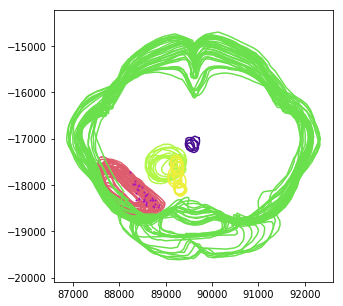

In [88]:
plt.figure(figsize=(5,5));

for name, cnts in contours.iteritems():    
    for cnt in cnts:
        plt.plot(cnt[:, 0], cnt[:, 1], c=contour_colors[name]);

for name, mkrs in markers.iteritems():
    plt.scatter(mkrs[:, 0], mkrs[:, 1], c=marker_colors[name], s=1, zorder=9);

plt.axis('equal');
    
# plt.title(name);

In [89]:
# contour coordinates are in um already.

In [90]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from annotation_utilities import *
from registration_utilities import *
from conversion import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
# x=left to right; y= superior to inferior (wrong! should be inferior to superior); z= anterior to posterior (they are coronal sections).

In [92]:
structure_subset = ['3N_L', 'RMC_L', 'SNR_L']

In [93]:
downscale = 32

In [94]:
markers_orientationCorrected = {convert_to_left_name(name_u): mkrs3d[:, [2,1,0]]*[1,-1,1]
                       for name_u, mkrs3d in markers.iteritems()}

In [95]:
markers_atlasResol = {name: mkrs3d / (XY_PIXEL_DISTANCE_LOSSLESS * downscale)
                       for name, mkrs3d in markers_orientationCorrected.iteritems()
                     if name in structure_subset}

In [96]:
contours_orientationCorrected = {convert_to_left_name(name_u): [cnt[:, [2,1,0]]*[1,-1,1]
                                 for cnt in cnts3d] 
                       for name_u, cnts3d in contours.iteritems()}

In [97]:
contours_atlasResol = {name: [cnt / (XY_PIXEL_DISTANCE_LOSSLESS * downscale)
                                for cnt in cnts3d] 
                       for name, cnts3d in contours_orientationCorrected.iteritems()
                                            if name in structure_subset}

In [98]:
# Generate and save surround score volumes. (in fact binary, but dtype is np.float16, same as interior score volumes.)

valid_level = .5

surround_distance_um = 200
surround_distance_voxel = surround_distance_um / XY_PIXEL_DISTANCE_TB
print "surround size (in voxels):", surround_distance_voxel

surround size (in voxels): 13.5869565217


In [99]:
vol_bbox_dict = {}
for name, cnts3d in contours_atlasResol.iteritems():
    vol_bbox_dict[name] = interpolate_contours_to_volume(interpolation_direction='x',
                                                    contours_xyz=cnts3d, 
                                                    len_interval=20)
    surr_name = convert_to_surround_name(name, margin=surround_distance_um)    
    vol_bbox_dict[surr_name] = get_surround_volume_v2(vol_bbox_dict[name][0], vol_bbox_dict[name][1], 
                                                      valid_level=valid_level, distance=surround_distance_voxel, prob=True)

In [100]:
volumes, volume_bbox = convert_vol_bbox_dict_to_overall_vol(vol_bbox_dict=vol_bbox_dict)

In [101]:
for s in volumes.keys():
    vol_fp = DataManager.get_score_volume_filepath(stack=stack, structure=s, downscale=32, volume_type='annotationAsScore')
    create_parent_dir_if_not_exists(vol_fp)
    bp.pack_ndarray_file(volumes[s], vol_fp)
    upload_to_s3(vol_fp)
    
    bbox_fp = DataManager.get_score_volume_bbox_filepath(stack=stack, structure=s, detector_id=None, prep_id=None, downscale=32, volume_type='annotationAsScore')
    create_parent_dir_if_not_exists(bbox_fp)
    np.savetxt(bbox_fp, volume_bbox)
    upload_to_s3(bbox_fp)

aws s3 cp "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_3N_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_3N_L.bp"
aws s3 cp "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_3N_L_bbox.txt" "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_3N_L_bbox.txt"
aws s3 cp "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNR_L.bp" "s3://mousebrainatlas-data/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNR_L.bp"
aws s3 cp "/shared/CSHL_volumes/LM40/LM40_down32_annotationAsScoreVolume/score_volumes/LM40_down32_annotationAsScoreVolume_SNR_L_bbox.txt" "s3://mousebrainatlas-data/CSHL

In [102]:
from data_manager import *

In [103]:
for name, mkrs in markers_atlasResol.iteritems():
    markers_fp = DataManager.get_lauren_markers_filepath(stack=stack, structure=name)
    create_parent_dir_if_not_exists(markers_fp)
    bp.pack_ndarray_file(markers_atlasResol[name], markers_fp)
    upload_to_s3(markers_fp)

aws s3 cp "/shared/lauren_data/markers/LM40/LM40_markers_SNR_L.bp" "s3://mousebrainatlas-data/lauren_data/markers/LM40/LM40_markers_SNR_L.bp"
